<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/object_detection/vehichile_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construction Vehicle Detection with Transformers

Train the transformer-based object detection model DETR on Hugging Face [excavator-detector dataset](!https://huggingface.co/datasets/keremberke/excavator-detector) to identifie construction vehicles like excavators, dump trucks, and wheel loaders using camera images

In [ ]:
!pip install datasets transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation

/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation


## 1. Load and split a Hugging Face construction vehicle dataset



In [16]:
from datasets import load_dataset
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

ds = load_dataset("keremberke/excavator-detector", name="full")

In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2245
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 267
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 144
    })
})

sample content:
image_id: 714
image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7903DBDF7410>
width: 640
height: 640
objects: {'id': [1001, 1002, 1003], 'area': [15876, 6530, 108117], 'bbox': [[257.0, 58.0, 126.0, 126.0], [168.0, 0.0, 86.5, 75.5], [87.0, 246.0, 293.0, 369.0]], 'category': [1, 1, 2]}



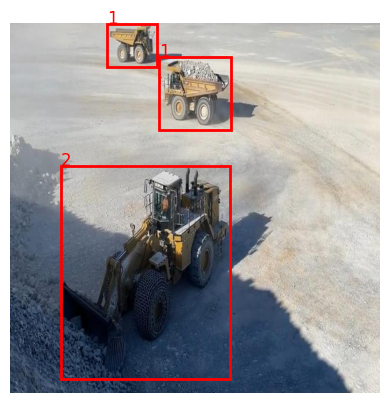

In [21]:
example = ds['train'][0]

# display example content
print(f"sample content:")
for key, value in example.items():
    print(f"{key}: {value}")

# display image
print()
plt.imshow(example['image'])
plt.axis("off")

# draw bounding boxes and category labels
ax = plt.gca() # gets the current Axes(area whitin the plot where image and annotations are displayed) object

# a loop though each detected object bounding box with coordinates x, y, width and height
# draw the their outlines on the image, retrive and add cotegory label
for i in range(len(example['objects']['bbox'])):
  bbox = example['objects']['bbox'][i]
  x, y, w, h = bbox
  rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  ax.add_patch(rect)

  plt.text(x, y, str(example['objects']['category'][i]), color='r', fontsize=12)


plt.show()

### Vehicle categorie names in dataset

In [25]:
# the feature metadata of the object column in the split contains the vehichle's categories
ds['train'].features['objects'].feature['category'].names

['excavators', 'dump truck', 'wheel loader']

In [28]:
# get unique category IDs
unique_category_ids = set()
for split in ds:  # Iterate through 'train', 'test', etc.
    for example in ds[split]:
        unique_category_ids.update(example['objects']['category'])

category_id_to_name = {
    i: feature
    for i, feature in enumerate(ds['train'].features['objects'].feature['category'].names)
}

# print category names
print("Object Category Names:")
for category_id in unique_category_ids:
    category_name = category_id_to_name.get(category_id, "Unknown")  # handle unknown IDs
    print(f"- {category_name}")

Object Category Names:
- excavators
- dump truck
- wheel loader
